In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.font_manager as fm

from konlpy.tag import Twitter
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from IPython.display import set_matplotlib_formats

%matplotlib inline

In [2]:
bill_20th = pd.read_csv('bill_20th_data_final.csv')
bill_20th.drop(['문서', '의결결과', '의안번호', '처리여부', '심사진행상태', '제안정당', 'Unnamed: 15'], axis=1, inplace=True)
bill_20th = bill_20th.fillna('')
print(bill_20th.shape)
bill_20th.head()

(23684, 30)


,의안명,제안자구분,제안일자,의결일자,제안회기,제안이유,소관위원회,제안자,법률반영여부,개혁보수신당,...,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,우리공화당,자유한국당,정의당
0,집합건물의 소유 및 관리에 관한 법률 일부개정법률안(김병관의원 등 13인),의원,2020-05-22,2020-05-29,제20대 (2016~2020) 제378회,아파트 등 공동주택은 「공동주택관리법」에 의해 체계적으로 관리되고 있는 반면 ...,법제사법위원회,"['김병관(더불어민주당/金炳官)', '고용진(더불어민주당/高榕禛)', '김병욱(더불...",미반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,지방세법 일부개정법률안(김병관의원 등 10인),의원,2020-05-22,2020-05-29,제20대 (2016~2020) 제378회,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 「부동산 가격...,행정안전위원회,"['김병관(더불어민주당/金炳官)', '김철민(더불어민주당/金哲玟)', '박재호(더불...",미반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,법률용어 정비를 위한 정보위원회 소관 2개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,제20대 (2016~2020) 제378회,,정보위원회,['김민기(더불어민주당/金敏基)'],반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,진실·화해를 위한 과거사정리 기본법 일부개정법률안(대안),위원장,2020-05-20,2020-05-20,제20대 (2016~2020) 제378회,,행정안전위원회,['전혜숙(더불어민주당/全惠淑)'],반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"화재예방, 소방시설 설치·유지 및 안전관리에 관한 법률 일부개정법률안(대안)",위원장,2020-05-20,2020-05-20,제20대 (2016~2020) 제378회,,행정안전위원회,['전혜숙(더불어민주당/全惠淑)'],반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
party_list = ['개혁보수신당', '국민의당', '대안신당', '대한애국당', '더불어민주당', '더불어시민당', '무소속',
       '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당', '민주평화당', '민중당', '바른미래당', '바른정당',
       '새누리당', '새로운보수당', '새민중정당', '우리공화당', '자유한국당', '정의당']

for party in party_list:
    print(f'{party}이 발의한 의안 개수:',bill_20th[bill_20th[f'{party}'] == 1].의안명.count())

개혁보수신당이 발의한 의안 개수: 59
국민의당이 발의한 의안 개수: 5649
대안신당이 발의한 의안 개수: 35
대한애국당이 발의한 의안 개수: 35
더불어민주당이 발의한 의안 개수: 16120
더불어시민당이 발의한 의안 개수: 22
무소속이 발의한 의안 개수: 3567
미래를향한전진4.0이 발의한 의안 개수: 4
미래통합당이 발의한 의안 개수: 94
미래한국당이 발의한 의안 개수: 43
민생당이 발의한 의안 개수: 20
민주평화당이 발의한 의안 개수: 3112
민중당이 발의한 의안 개수: 226
바른미래당이 발의한 의안 개수: 4659
바른정당이 발의한 의안 개수: 1091
새누리당이 발의한 의안 개수: 2041
새로운보수당이 발의한 의안 개수: 23
새민중정당이 발의한 의안 개수: 24
우리공화당이 발의한 의안 개수: 42
자유한국당이 발의한 의안 개수: 6967
정의당이 발의한 의안 개수: 2362


In [2]:
6967 + 2041 + 4659 + 94 + 43

13804

In [1]:
16120 + 22

16142

#### __정당에 관하여__

1) 어떤정당이 일을 얼마나 잘했는가는 큰 의미가 없는 분석이 될 듯.  
- 보수정당은 너무 많이 바뀌어서 개별 정당의 의안 수가 이름이 바뀌지 않은 더불어민주당에 비해 턱없이 부족

2) 참고할만한 이벤트
>ㄱ. 박근헤 직무정지 : 2016-12-09  
ㄴ. 새누리당, 자유한국당으로 당명 변경 : 2017-02-17  
ㄷ. 미래통합당 창당 : 2020-02-17

3) 합당이나 탈당이 아닌 이름만 바뀐 당은 합치는 것이 맞을 듯?
>ㄱ. 당을 만든 후 공모를 통해 당명을 정한 경우 : 개혁보수신당 = 바른정당  
ㄴ. 위성정당 : 미래통합당 + 미래한국당 & 더불어민주당 + 더불어시민당

In [4]:
## 의안명과 제안이유 칼럼 결합
bill_20th['의안명'] = bill_20th['의안명'].str.split('(').str[0]
bill_20th['의안명과 제안이유'] = bill_20th['의안명'] + ' ' + bill_20th['제안이유']
bill_20th.head()

,의안명,제안자구분,제안일자,의결일자,제안회기,제안이유,소관위원회,제안자,법률반영여부,개혁보수신당,...,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,우리공화당,자유한국당,정의당,의안명과 제안이유
0,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,제20대 (2016~2020) 제378회,아파트 등 공동주택은 「공동주택관리법」에 의해 체계적으로 관리되고 있는 반면 ...,법제사법위원회,"['김병관(더불어민주당/金炳官)', '고용진(더불어민주당/高榕禛)', '김병욱(더불...",미반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,집합건물의 소유 및 관리에 관한 법률 일부개정법률안 아파트 등 공동주택은 「공동...
1,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,제20대 (2016~2020) 제378회,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 「부동산 가격...,행정안전위원회,"['김병관(더불어민주당/金炳官)', '김철민(더불어민주당/金哲玟)', '박재호(더불...",미반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,지방세법 일부개정법률안 현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부...
2,법률용어 정비를 위한 정보위원회 소관 2개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,제20대 (2016~2020) 제378회,,정보위원회,['김민기(더불어민주당/金敏基)'],반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,법률용어 정비를 위한 정보위원회 소관 2개 법률 일부개정을 위한 법률안
3,진실·화해를 위한 과거사정리 기본법 일부개정법률안,위원장,2020-05-20,2020-05-20,제20대 (2016~2020) 제378회,,행정안전위원회,['전혜숙(더불어민주당/全惠淑)'],반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,진실·화해를 위한 과거사정리 기본법 일부개정법률안
4,"화재예방, 소방시설 설치·유지 및 안전관리에 관한 법률 일부개정법률안",위원장,2020-05-20,2020-05-20,제20대 (2016~2020) 제378회,,행정안전위원회,['전혜숙(더불어민주당/全惠淑)'],반영,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"화재예방, 소방시설 설치·유지 및 안전관리에 관한 법률 일부개정법률안"


## 1. 텍스트 데이터 전처리
한글과 영문을 제외한 특수문자 제거

In [5]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [6]:
bill_20th['의안명과 제안이유'] = bill_20th['의안명과 제안이유'].apply(preprocessing)
bill_20th['의안명과 제안이유'][:20]

0     집합건물의 소유 및 관리에 관한 법률 일부개정법률안   아파트 등 공동주택은  공동...
1     지방세법 일부개정법률안 현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부...
2              법률용어 정비를 위한 정보위원회 소관  개 법률 일부개정을 위한 법률안 
3                          진실 화해를 위한 과거사정리 기본법 일부개정법률안 
4               화재예방  소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안 
5     행정사법 일부개정법률안 복잡하고 다양한 행정 수요 증가에 대응하여 전문적인 행정사 ...
6                                재난 및 안전관리 기본법 일부개정법률안 
7                            자전거 이용 활성화에 관한 법률 일부개정법률안 
8                                        지방재정법 일부개정법률안 
9               부마민주항쟁 관련자의 명예회복 및 보상 등에 관한 법률 일부개정법률안 
10                              집회 및 시위에 관한 법률 일부개정법률안 
11                                    소방시설공사업법 일부개정법률안 
12    일제하 일본군위안부 피해자에 대한 보호 지원 및 기념사업 등에 관한 법률 일부개정법...
13                        다중이용업소의 안전관리에 관한 특별법 일부개정법률안 
14                                       도로교통법 일부개정법률안 
15                      소규모 공공시설 안전관리 등에 관한 법률 일부개정법률안 
16    양육비 이행확보 및 지원에 관한 법률 일부개정법률안 대안의 한시적 양육비 긴급지원이...
17    아동 청소년의 성보호에 관한 법률 일부개정법률안    대안의 아동 청소년 음

## 2. 정당별 데이터프레임 만들기

In [7]:
## 주요 정당별 정당 발의 의안 dfm 생성

## 보수당
aegook = bill_20th[bill_20th['대한애국당'] == 1]
saenuri = bill_20th[bill_20th['새누리당'] == 1]
jayu = bill_20th[bill_20th['자유한국당'] == 1]
mirae = bill_20th[(bill_20th['미래통합당'] == 1) | (bill_20th['미래한국당'] == 1)]

## 중도/보수
gookmin = bill_20th[bill_20th['국민의당'] == 1]
pyeonghwa = bill_20th[bill_20th['민주평화당'] == 1]
bareun = bill_20th[bill_20th['바른미래당'] == 1]

## 중도/진보
theminzu = bill_20th[(bill_20th['더불어민주당'] == 1) | (bill_20th['더불어시민당'] == 1)]

## 진보
jeongyui = bill_20th[bill_20th['정의당'] == 1]

## 급진
minjung = bill_20th[bill_20th['민중당'] == 1]

musosok = bill_20th[bill_20th['무소속'] == 1]

## 3. 워드클라우드

### 3.1 불용어 처리전

In [8]:
from soynlp.tokenizer import RegexTokenizer

tokenizer = RegexTokenizer()
%time tokens = saenuri['의안명과 제안이유'].apply(tokenizer.tokenize)
tokens[:3]

C:\Users\NK\Anaconda3\lib\site-packages\soynlp\tokenizer\_tokenizer.py:19: FutureWarning: Possible nested set at position 13
  ('english & latin', re.compile(u"[a-zA-ZÀ-ÿ]+[[`']?s]*|[a-zA-ZÀ-ÿ]+", re.UNICODE))


Wall time: 2.11 s


10692    [정보통신망, 이용촉진, 및, 정보보호, 등에, 관한, 법률, 일부개정법률안, 대안...
10702    [정부조직법, 일부개정법률안, 수량, 수질의, 통일적, 관리와, 지속가능한, 물, ...
10703    [도로교통법, 일부개정법률안, 대안의, 법적, 구속력, 있는, 명확한, 교통안전시설...
Name: 의안명과 제안이유, dtype: object

In [9]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

## 폰트를 지정합니다
fontpath = 'C:/Windows/Fonts/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

## 불용어를 지정합니다.
stopwords_kr = [] 

In [10]:
def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(font_path = fontpath, 
                          stopwords = stopwords_kr, 
                          background_color = backgroundcolor, 
                          width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

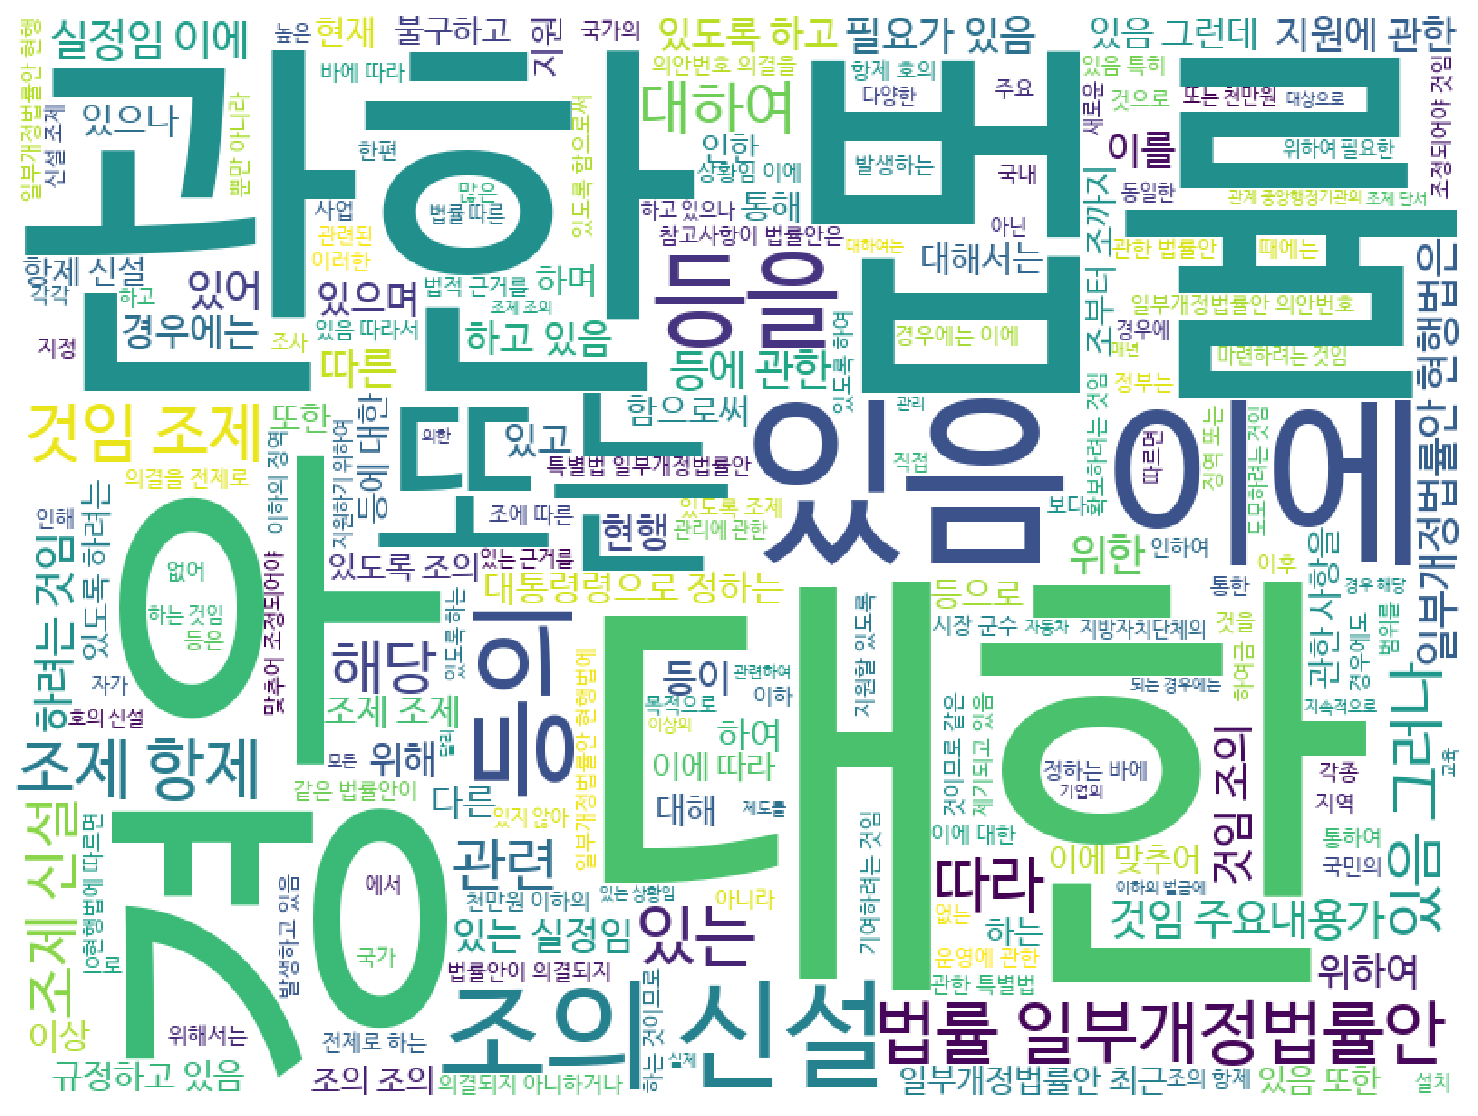

Wall time: 4.91 s


In [11]:
%time displayWordCloud(' '.join(saenuri['의안명과 제안이유']))

#### 3.2 LRNounExtractor를 이용, 명사만 추출

In [12]:
%%time
noun_extractor = LRNounExtractor(verbose=True)
noun_extractor.train(saenuri['의안명과 제안이유'])
nouns = noun_extractor.extract()

[Noun Extractor] used default noun predictor; Sejong corpus predictor
[Noun Extractor] used noun_predictor_sejong
[Noun Extractor] All 2398 r features was loaded
[Noun Extractor] scanning was done (L,R) has (18904, 10291) tokens
[Noun Extractor] building L-R graph was done
[Noun Extractor] 4954 nouns are extracted
Wall time: 4.75 s


In [13]:
nouns

{'감소': NounScore_v1(frequency=74, score=0.9557892978723405, known_r_ratio=0.8545454545454545),
 '상임': NounScore_v1(frequency=6, score=0.9997250000000001, known_r_ratio=0.09090909090909091),
 '징수': NounScore_v1(frequency=136, score=0.9279931267605634, known_r_ratio=0.6574074074074074),
 '임업': NounScore_v1(frequency=20, score=0.999867, known_r_ratio=0.16666666666666666),
 '상수': NounScore_v1(frequency=9, score=0.505755, known_r_ratio=0.4444444444444444),
 '건전': NounScore_v1(frequency=80, score=0.9995330750000001, known_r_ratio=0.7843137254901961),
 '추적': NounScore_v1(frequency=9, score=0.504724, known_r_ratio=0.3333333333333333),
 '징집': NounScore_v1(frequency=9, score=1.0, known_r_ratio=0.5),
 '유효': NounScore_v1(frequency=53, score=0.9971226666666667, known_r_ratio=0.05660377358490566),
 '검정': NounScore_v1(frequency=4, score=0.8320016666666668, known_r_ratio=0.75),
 '사격': NounScore_v1(frequency=6, score=0.834543, known_r_ratio=0.11538461538461539),
 '당원': NounScore_v1(frequency=5, score=0

#### 3.3 불용어 처리

In [ ]:
bill_list = []
for i in aegook['의안명과 제안이유']:
    bill_list.append(i)

In [ ]:
from konlpy.tag import Twitter
nlpy = Twitter()
nouns = nlpy.nouns(str(bill_list))
%time count = Counter(nouns)

In [ ]:
tag_count = []
tags = []

for n, c in count.most_common(100):
    dics = {'tag': n, 'count': c}
    if len(dics['tag']) >= 2 and len(tags) <= 49:
        tag_count.append(dics)
        tags.append(dics['tag'])

for tag in tag_count:
    print(" {:<14}".format(tag['tag']), end='\t')
    print("{}".format(tag['count']))

In [14]:
stopwords_list = ['법률', '경우', '대한', '일부', '개정','것임', '관련','현행법','위원회','조의',\
                  '조제', '관련', '내용', '사항', '발생', '행위', '운영', '업무','이상', '신설', '규정',\
                  '사업', '해당', '기준', '마련', '설치', '사항', '대상', '또는', '있음']

#### 3.4 워드클라우드 그리기

In [61]:
def wordcloud(text_list):
    
    twitter = Twitter()
    morphs = []
    nv = []
    
    for sentence in text_list:
        morphs.append(twitter.pos(sentence))
    
    # 명사, 동사만 & 추가 조건
    for sentence in morphs:
        for word, tag in sentence:
            if (tag == ('Noun' or 'Verb')) and (len(word)!=1):
                nv.append(word)
                
    unique_Noun_words = set(nv)
    for word in unique_Noun_words:
        if word in stopwords_list:
            while word in nv: nv.remove(word)  # 최종결과 : Noun_words
                
    # 빈도수 정렬
    count = Counter(nv)
    wordfreq = dict(count.most_common())
    

    
    # 디스플레이 설정
    
    matplotlib.rc('font',family = 'Malgun Gothic') 
    set_matplotlib_formats('retina') 
    matplotlib.rc('axes',unicode_minus = False)

    wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/NanumBarunGothic.ttf',
                          background_color='white',colormap = "Accent_r",
                          stopwords = stopwords_list,
                          width=3000, height=2000).generate_from_frequencies(wordfreq) 
    plt.imshow(wordcloud) 
    plt.axis('off') 
    plt.show()

    return wordfreq

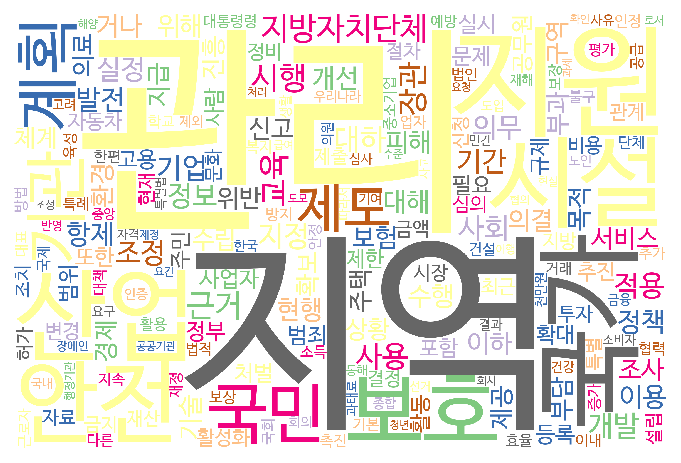

Wall time: 6min 56s


{'관리': 1696,
 '지역': 1535,
 '지원': 1506,
 '국가': 1182,
 '산업': 1038,
 '시설': 997,
 '안전': 901,
 '보호': 871,
 '국민': 857,
 '기관': 812,
 '계획': 797,
 '제도': 795,
 '지방자치단체': 771,
 '교육': 764,
 '근거': 760,
 '시행': 756,
 '장관': 724,
 '대하': 665,
 '사용': 657,
 '지정': 651,
 '개발': 649,
 '기업': 638,
 '사회': 628,
 '적용': 627,
 '조정': 614,
 '기간': 607,
 '정보': 606,
 '의무': 593,
 '발전': 584,
 '실정': 569,
 '항제': 560,
 '정책': 559,
 '이용': 543,
 '대해': 539,
 '개선': 528,
 '수행': 515,
 '위해': 508,
 '거나': 507,
 '현행': 504,
 '피해': 497,
 '이하': 496,
 '보험': 493,
 '의결': 490,
 '조사': 487,
 '기술': 485,
 '목적': 479,
 '서비스': 474,
 '신고': 474,
 '위반': 474,
 '환경': 474,
 '확보': 467,
 '상황': 462,
 '수립': 459,
 '지급': 458,
 '주택': 457,
 '구역': 454,
 '부과': 453,
 '부담': 453,
 '진흥': 446,
 '경제': 445,
 '제공': 443,
 '체계': 440,
 '의료': 438,
 '사업자': 433,
 '또한': 430,
 '정부': 427,
 '등록': 427,
 '문제': 420,
 '필요': 416,
 '공무원': 416,
 '범죄': 414,
 '처벌': 408,
 '포함': 407,
 '확대': 402,
 '실시': 398,
 '고용': 395,
 '범위': 394,
 '추진': 391,
 '활동': 386,
 '사람': 386,
 '제한': 383,
 '주민': 383,
 '규제

In [49]:
%time wordcloud(saenuri['의안명과 제안이유'])

In [51]:
%time wordcloud(jayu['의안명과 제안이유'])

KeyboardInterrupt: 

In [34]:
theminzu.groupby('소관위원회')['의안명'].count().sort_values()[::-1]

소관위원회
행정안전위원회                          1889
보건복지위원회                          1780
국토교통위원회                          1486
환경노동위원회                          1400
기획재정위원회                          1353
법제사법위원회                          1231
농림축산식품해양수산위원회                    1186
정무위원회                            1123
산업통상자원중소벤처기업위원회                   788
과학기술정보방송통신위원회                     669
교육위원회                             651
문화체육관광위원회                         599
국회운영위원회                           383
국방위원회                             367
여성가족위원회                           288
외교통일위원회                           271
                                  194
교육문화체육관광위원회                       135
안전행정위원회                            98
정치개혁 특별위원회                         82
산업통상자원위원회                          55
윤리특별위원회                            22
헌법개정 및 정치개혁 특별위원회                  22
정보위원회                              20
사법개혁 특별위원회                         13
미래창조과학방송통신위원회                       8
헌법재판소 

## 4. LDA

In [ ]:
gookmin_hang = gookmin[gookmin['소관위원회'] == '행정안전위원회']

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

twitter = Twitter()
morphs = []
nv = []

for sentence in gookmin_hang['의안명과 제안이유']:
    morphs.append(twitter.pos(sentence))
    
for sentence in morphs:
    for word, tag in sentence:
        if (tag == ('Noun' or 'Verb')) and (len(word)!=1):
            nv.append(word)

In [45]:
count_vect = CountVectorizer(max_df = 0.95, max_features = 1000, min_df = 3, stop_words = stopwords_list, ngram_range = (1,2))
feat_vect = count_vect.fit_transform(nv)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (71872, 1000)


In [46]:
lda = LatentDirichletAllocation(n_components = 5, random_state = 0)
lda.fit(feat_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [47]:
def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)
        
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes = topic_word_indexes[:no_top_words]
        
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)
        
feature_names = count_vect.get_feature_names()

display_topics(lda, feature_names, 15)

Topic # 0
공무원 국민 후보자 지원 보호 소방 기관 어린이 대통령 투표 지방의회 재난 문제 구역 목적
Topic # 1
지방자치단체 지역 의결 의원 주민 기간 사용 필요 실정 대해 또한 교육 재정 금지 조사
Topic # 2
활동 사회 번호 수행 제한 정치 근거 현행 확보 위해 거나 항제 발전 최근 기부
Topic # 3
관리 선거 국가 지방 시설 사람 의무 정당 정책 의안 정보 피해 보장 단체 상황
Topic # 4
안전 제도 대하 지정 이용 위반 소속 실시 지방세 도로 범위 특례 방지 자유 기여
